# Python analysis

Similarly to what we have done for the C library, we will study the performances of an operation on sets, the union, for various sizes and densities of the datasets as well as various implementations.

We consider three implementations:

  - The built-in **set**.
  - An implementation of Roaring Bitmaps in Cython, which can be found [here](https://github.com/andreasvc/roaringbitmap). We will designate it as **cyroaring** in the following.
  - A Python wrapper  for the C implementation of Roaring Bitmaps, which can be found [here](https://github.com/Ezibenroc/PyRoaringBitMap). We will designate it as **pyroaring** in the following.

To obtain the results, we use a Python script that runs the experiments with the given parameters and outputs the results in the given CSV file.

The size of the roaring bitmaps are given by the arguments `--size1` and `--size2`, their densities by the arguments `--density1` and `--density2`. Sizes are integers, densities are floats.
These arguments can be a single value (e.g. `--size1 27`), a list of values (e.g. `--size1 32,64,128,256`) or a range of values (e.g. `--size1 1:1000`).
The value actually used for each experiment is sampled randomly and uniformly in the given list (resp. range).

The argument `--size2` (resp. `--density2`) can be omitted. In this case, the random value used for each experiment will be exactly the same than the one used for the first size (resp. the first density). In this case, the two sizes (resp. densities) are therefore not independent anymore.

In [1]:
library(ggplot2)

The following results have been obtained with the command:
```bash
export LD_LIBRARY_PATH="`pwd`/build/:$LD_LIBRARY_PATH"
./scripts/python_size_density_runner.py\
    --size1 1:10000000 --size2 1:10000000\
    --density1 0.01,0.04,0.1,0.5,0.999\
    -n 600 results/python_results.csv
```

Size of the two roaring bitmaps are sampled randomly and uniformly in [0, 10^7], a density is sampled randomly and uniformly in {0.01, 0.04, 0.1, 0.5, 0.999} (same density for the two bitmaps).

In a first time, we will compare the three implementations for a given density. Then we will compare the different densities for a given implementation.

All plots use a log scale for the time axis.

In [2]:
all_times_broadwell = read.csv("results/broadwell_python_results.csv")
all_times_broadwell$density1 <- factor(all_times_broadwell$density1)
all_times_broadwell$class <- factor(all_times_broadwell$class)
all_times_broadwell$size_sum <- apply(all_times_broadwell[,c('size1','size2')], 1, function(y) sum(y['size1'],y['size2'])) # can also take the max
    
all_times_skylake = read.csv("results/skylake_python_results.csv")
all_times_skylake$density1 <- factor(all_times_skylake$density1)
all_times_skylake$class <- factor(all_times_skylake$class)
all_times_skylake$size_sum <- apply(all_times_skylake[,c('size1','size2')], 1, function(y) sum(y['size1'],y['size2'])) # can also take the max

## Broadwell

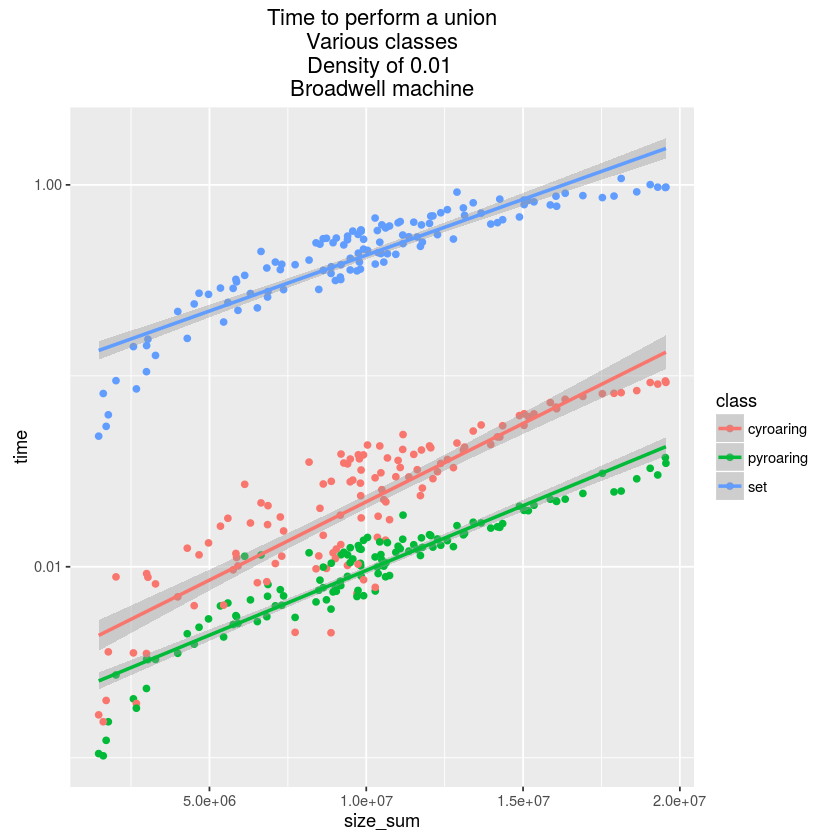

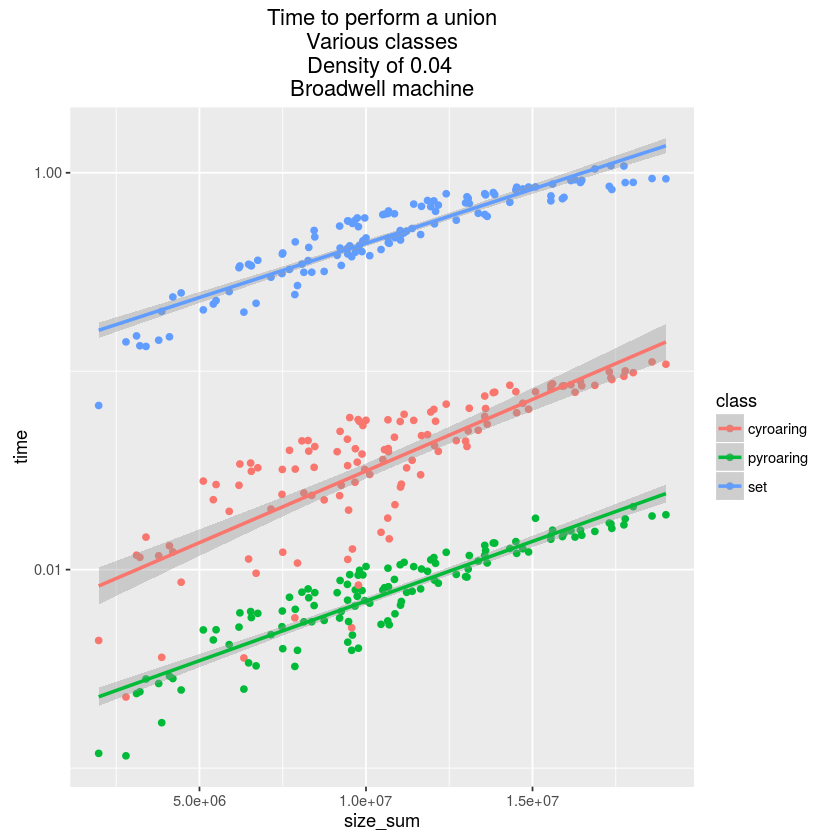

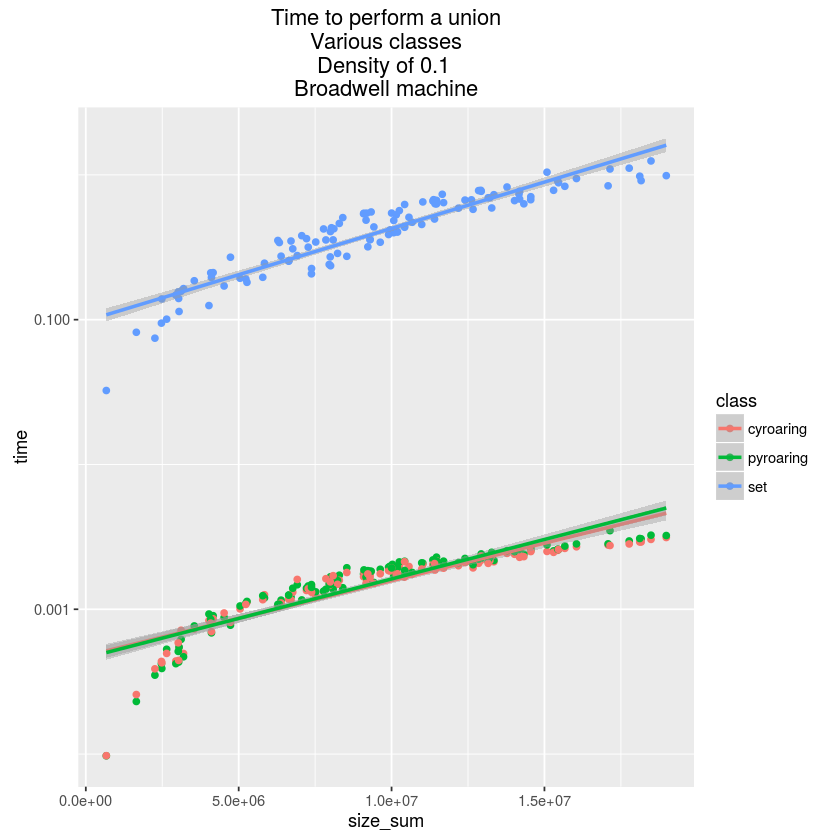

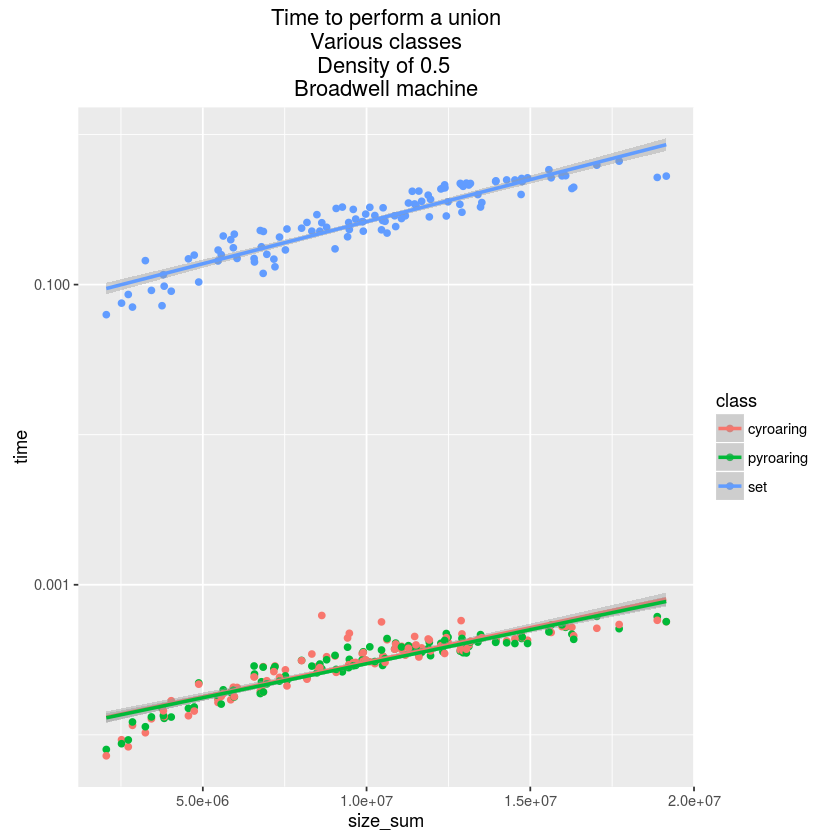

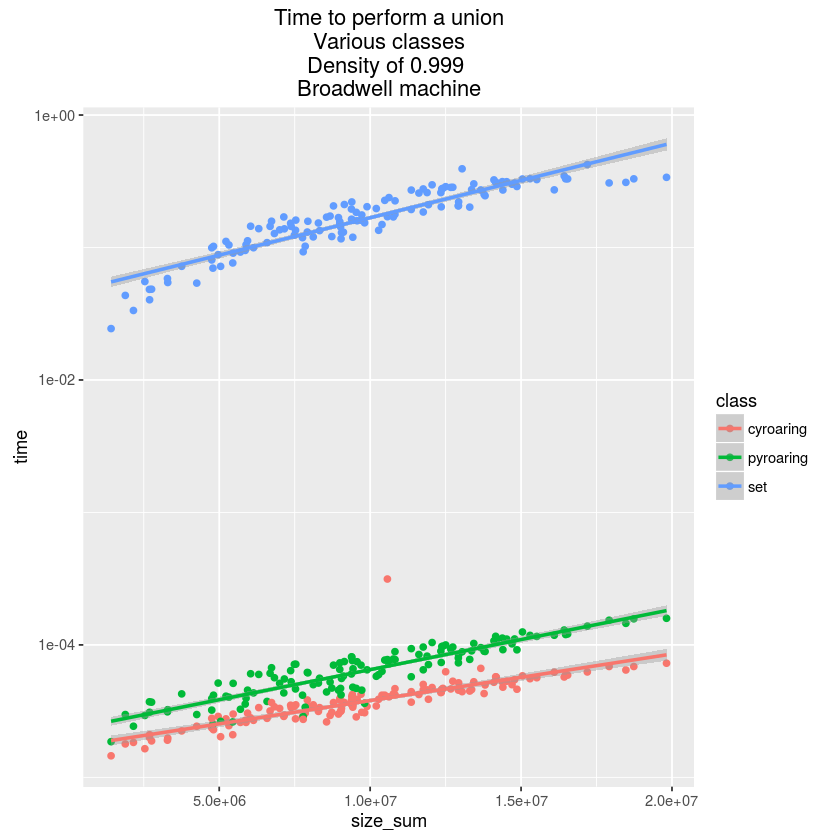

In [3]:
for(density in sort(unique(all_times_broadwell[,'density1']))) {
    title <- paste("Time to perform a union\nVarious classes\nDensity of", density, "\nBroadwell machine")
    print(ggplot(all_times_broadwell[all_times_broadwell['density1'] == density,], aes(x=size_sum, y=time, group=class, colour=class))+
                geom_point() + geom_smooth(method=lm) +
                ggtitle(title) +
                scale_y_log10()
    )
}

It is clear that the built-in `set` is much slower than the two implementations of roaring bitmaps (roughly two orders of magnitude). It was expected, since it is much more generic: it can store any Python object, provided that it implements the `__eq__` and `__hash__` methods.

For sparse data, `pyroaring` is significantly faster than `cyroaring`.

For densities of 0.1 and 0.5, the two implementations seem to have similar performances. It is rather surprising, we could expect the C implementation to always be faster.

For the density of 0.999, `cyroaring` is clearly faster. An hypothesis for this is that `cyroaring` uses different data structures, as mentionned [in comment](https://github.com/andreasvc/roaringbitmap/blob/7cba9eae8115ca705bbe08ffb8c992208b74bf05/src/roaringbitmap.pyx#L8-L15). It does not use run containers. Instead, when the number of values is greater than 2^16 - 2^14, it uses a container similar to array containers to store values that are not in the set. This corresponds to densities greater or equal to 0.9375, which would explain the difference for the 0.999 density.

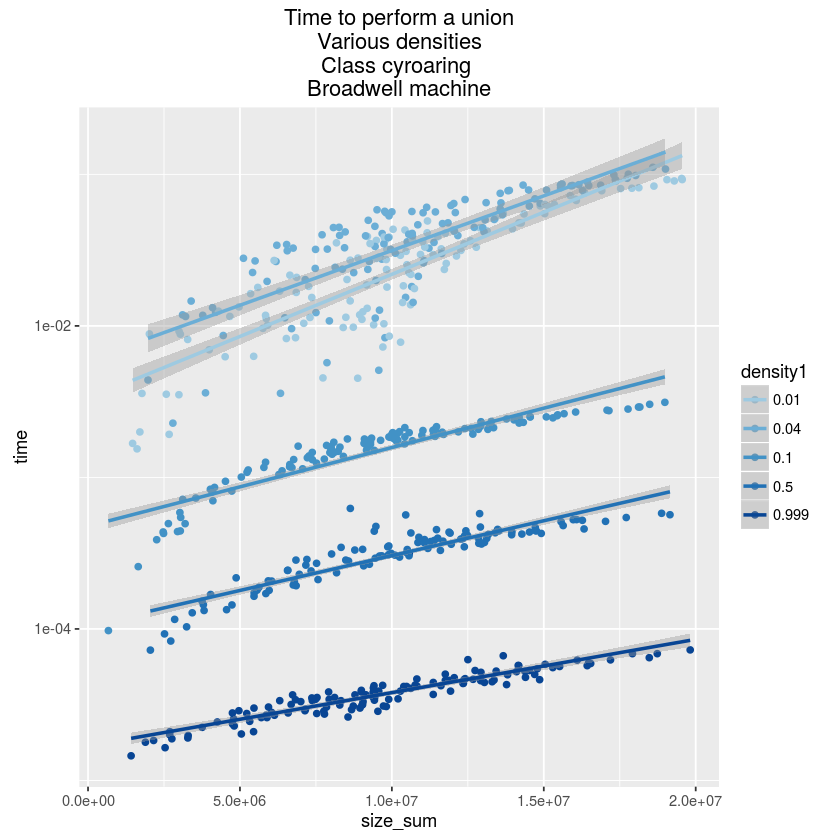

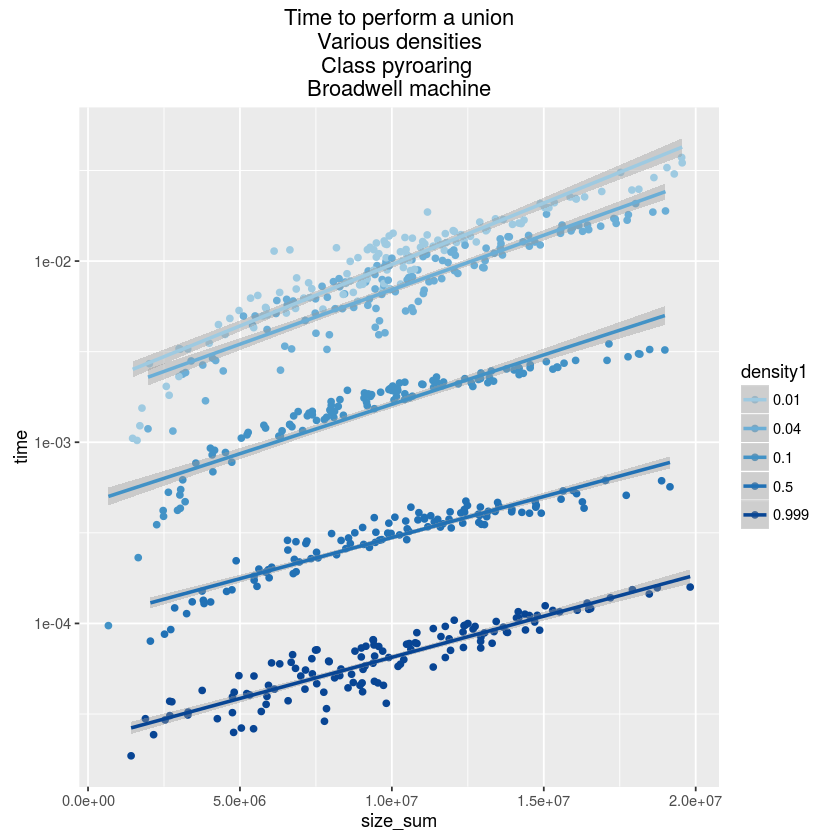

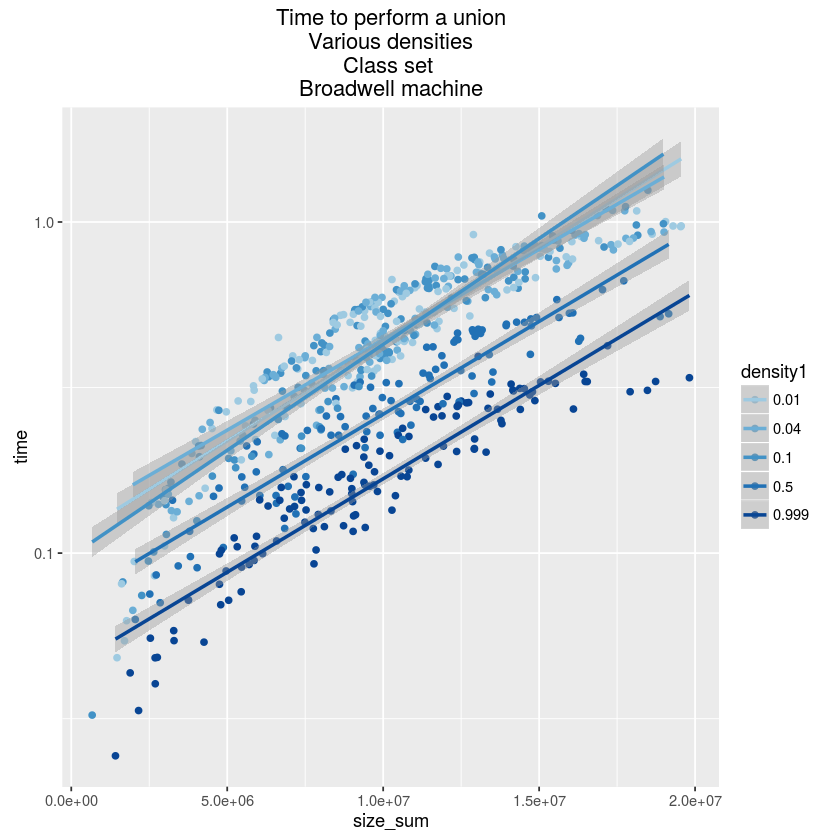

In [4]:
library(RColorBrewer)
my_colors = brewer.pal(n = 7, "Blues")[3:7] # we exclude the lightest colors


for(class in sort(unique(all_times_broadwell[,'class']))) {
    title <- paste("Time to perform a union\nVarious densities\nClass", class, "\nBroadwell machine")
    print(ggplot(all_times_broadwell[all_times_broadwell['class'] == class,], aes(x=size_sum, y=time, group=density1, colour=density1))+
            geom_point() + geom_smooth(method=lm) +
            ggtitle(title) +
            scale_colour_manual(values=my_colors) +
            scale_y_log10()
    )
}

For all implementations, the operation is faster with high densities.

It can be surprising for `set`, since it is based on a hash table. One could think that its performances would not depend on the densities. The reason why we observe different performances is very well explained in [this stackoverflow answer](http://stackoverflow.com/a/42079699/4110059). In Python, the hash of an integer is the integer itself, then the `set` class takes its modulo with the number of buckets. For dense data, each element is smaller than the number of buckets, so they are naturally well spread: there is no collision. For sparse data, a lot of elements are greater than the number of buckets, so the modulo might create collisions.

This difference of performances for different densities is expected for implementations of roaring bitmaps. With high densities `bitset` containers will be used whereas for low densities `array` containers will be used.

One strange observation is that with `pyroaring` we can see better performances for a density of 0.04 than for 0.01, but with `cyroaring` there are better performances for a density of 0.01 than for 0.04.

## Skylake

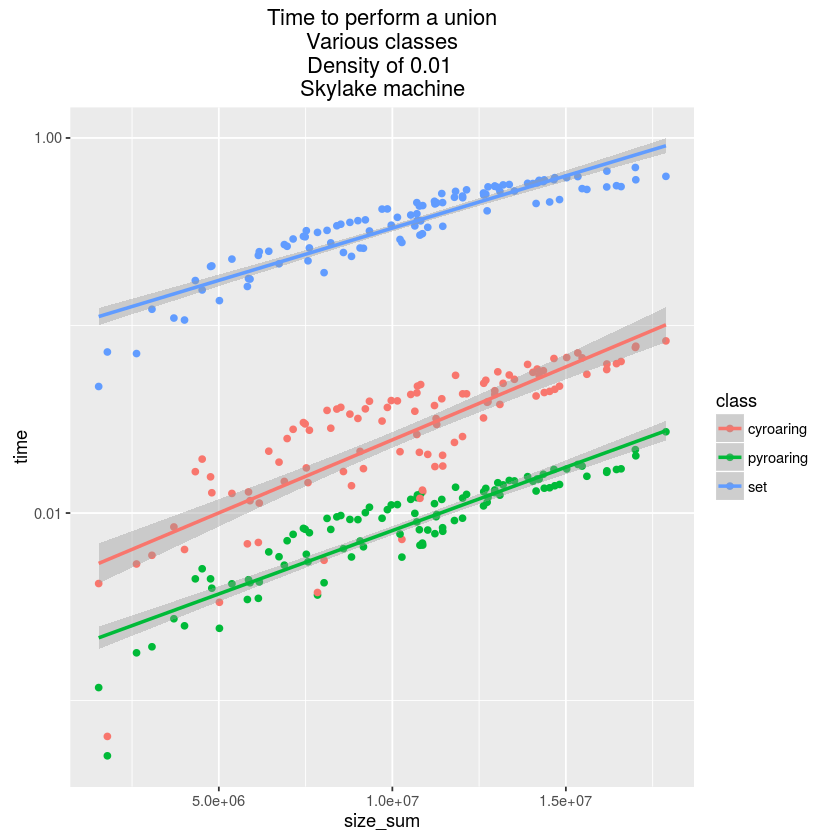

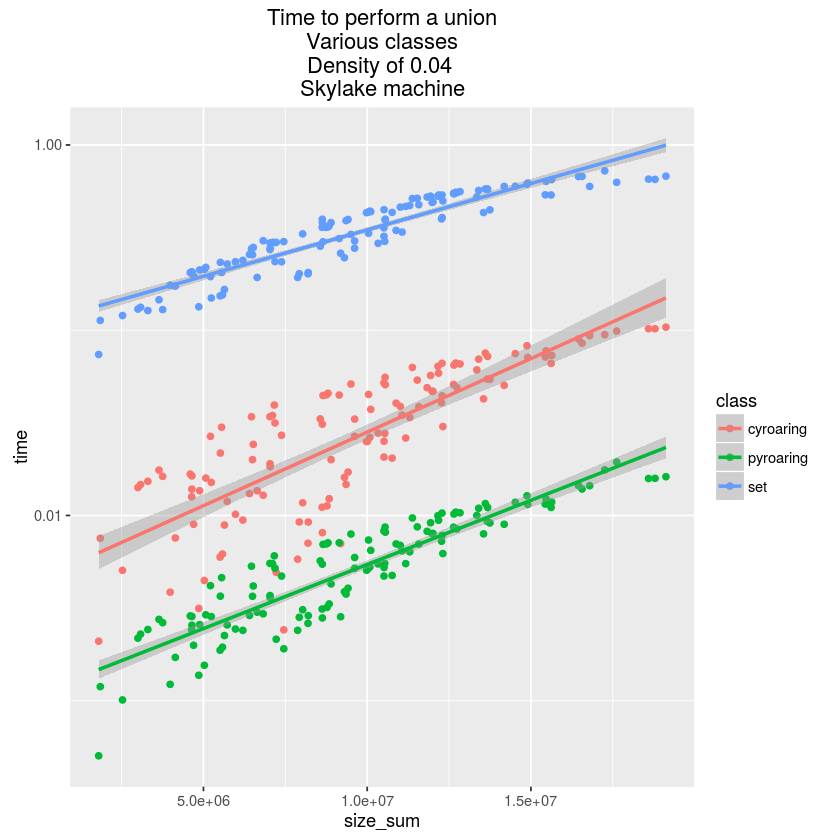

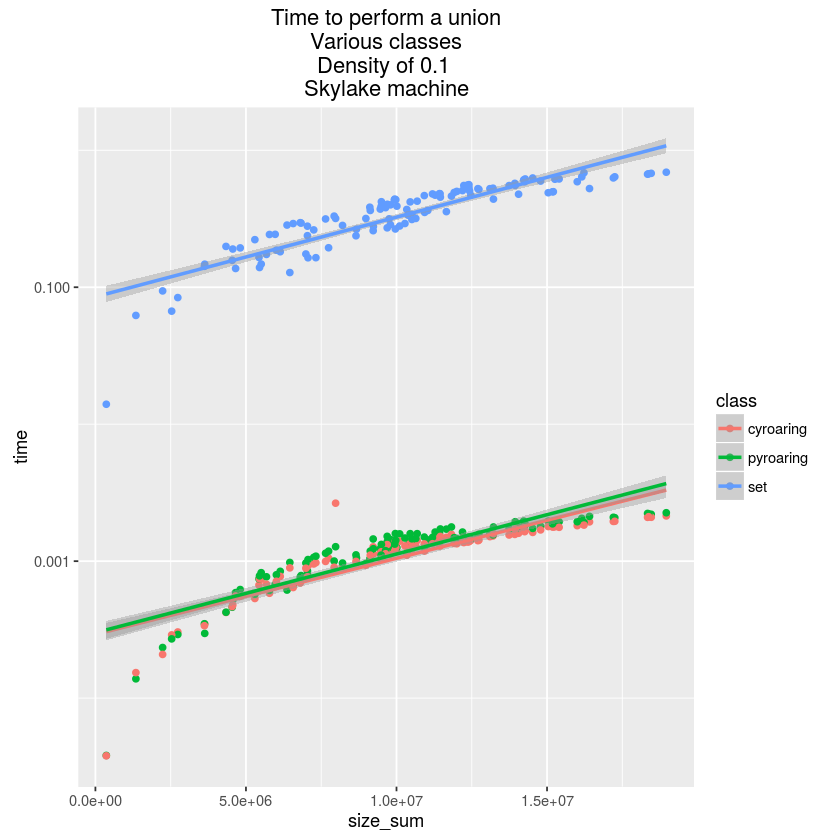

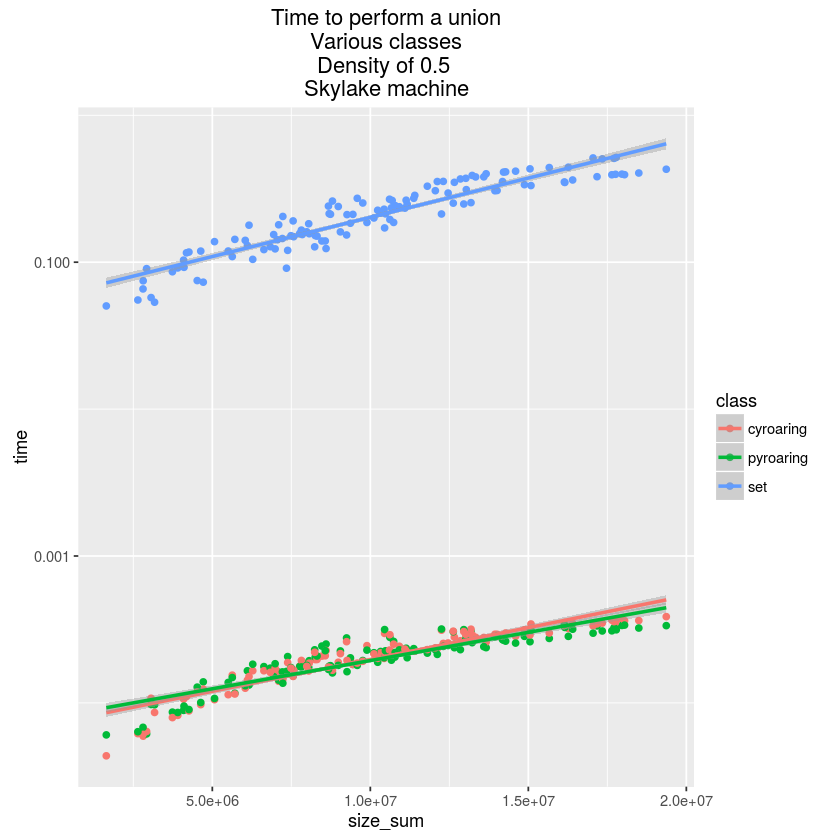

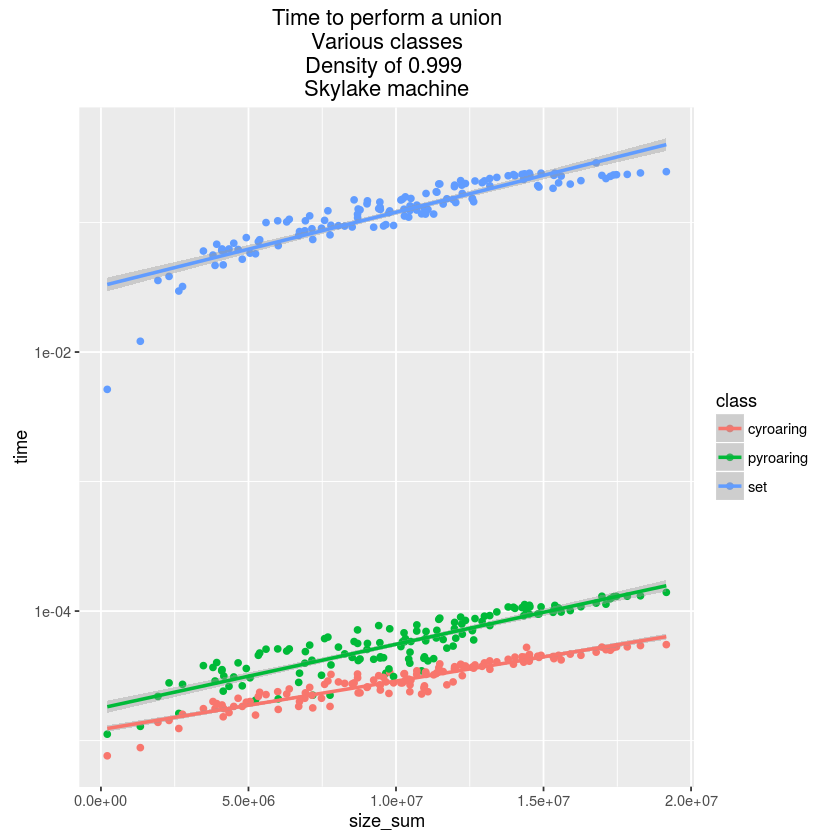

In [5]:
for(density in sort(unique(all_times_skylake[,'density1']))) {
    title <- paste("Time to perform a union\nVarious classes\nDensity of", density, "\nSkylake machine")
    print(ggplot(all_times_skylake[all_times_skylake['density1'] == density,], aes(x=size_sum, y=time, group=class, colour=class))+
                geom_point() + geom_smooth(method=lm) +
                ggtitle(title) +
                scale_y_log10()
    )
}

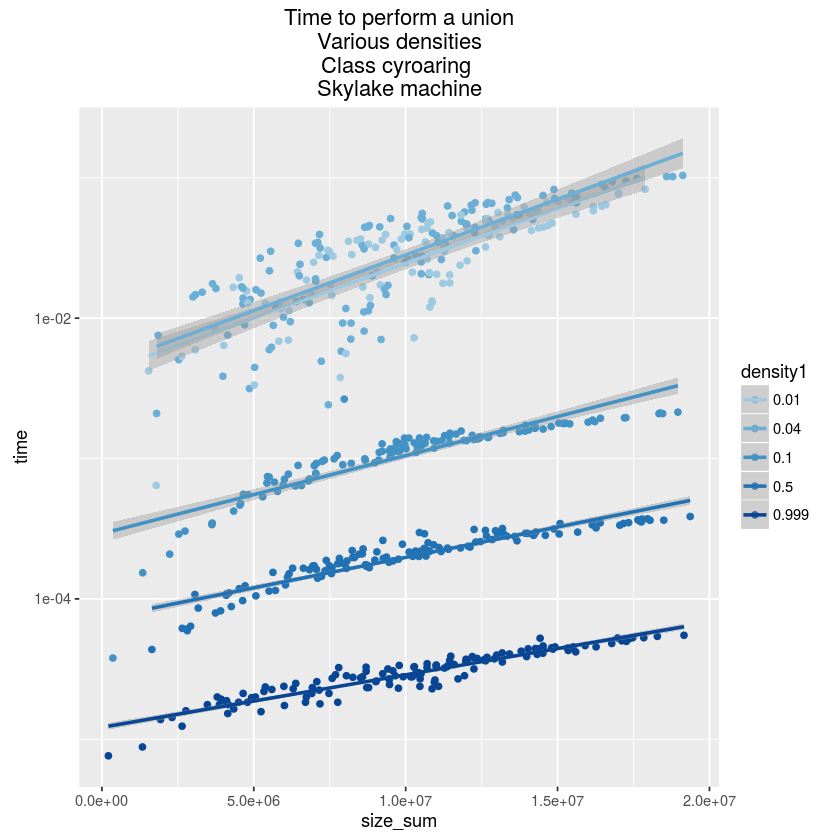

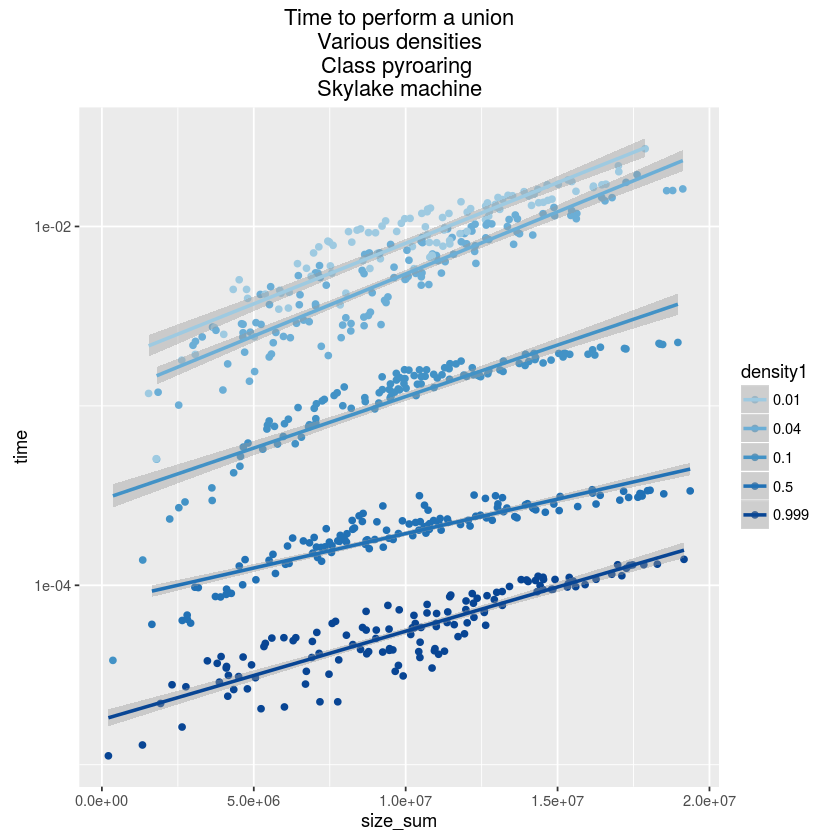

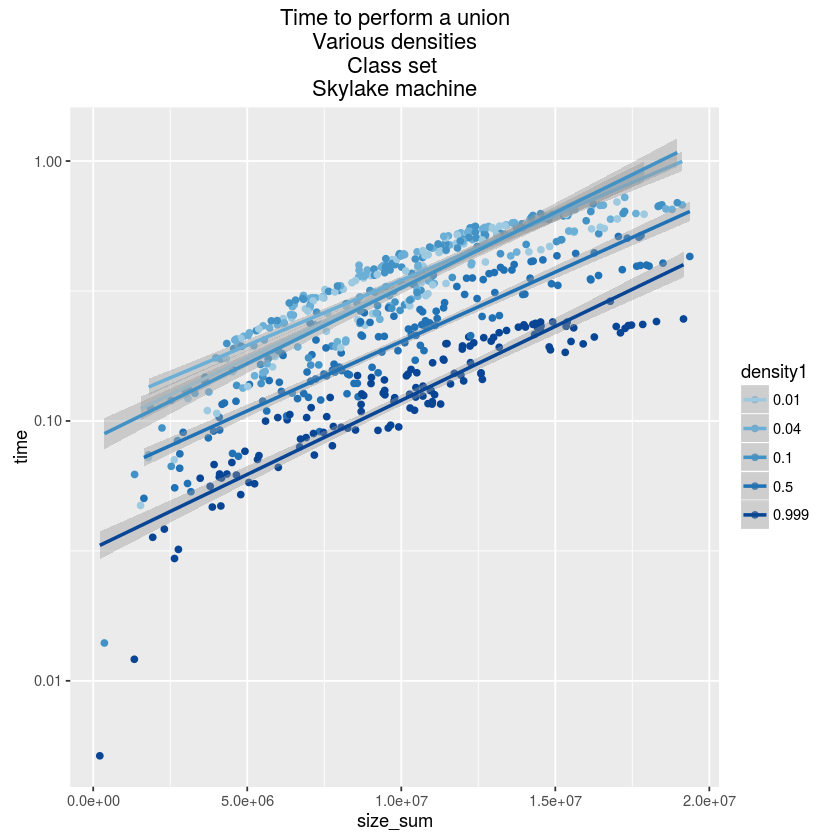

In [6]:
for(class in sort(unique(all_times_skylake[,'class']))) {
    title <- paste("Time to perform a union\nVarious densities\nClass", class, "\nSkylake machine")
    print(ggplot(all_times_skylake[all_times_skylake['class'] == class,], aes(x=size_sum, y=time, group=density1, colour=density1))+
            geom_point() + geom_smooth(method=lm) +
            ggtitle(title) +
            scale_colour_manual(values=my_colors) +
            scale_y_log10()
    )
}

We get similar plots with the Skylake machine.

## Conclusion

In [7]:
for(density in sort(unique(all_times_broadwell[,'density1']))) {
    print(paste('density =', density))
    print(lm(time~size_sum, data=all_times_broadwell[all_times_broadwell['density1'] == density & all_times_broadwell['class'] == 'pyroaring',])$coefficients)
}


[1] "density = 0.01"
  (Intercept)      size_sum 
-4.219559e-03  1.599490e-09 
[1] "density = 0.04"
  (Intercept)      size_sum 
-2.581541e-03  1.071203e-09 
[1] "density = 0.1"
 (Intercept)     size_sum 
1.138757e-04 1.703118e-10 
[1] "density = 0.5"
 (Intercept)     size_sum 
3.146755e-05 2.921997e-11 
[1] "density = 0.999"
 (Intercept)     size_sum 
4.779244e-07 7.145504e-12 


In [8]:
for(density in sort(unique(all_times_skylake[,'density1']))) {
    print(paste('density =', density))
    print(lm(time~size_sum, data=all_times_skylake[all_times_skylake['density1'] == density & all_times_skylake['class'] == 'pyroaring',])$coefficients)
}

[1] "density = 0.01"
  (Intercept)      size_sum 
-2.628096e-03  1.220274e-09 
[1] "density = 0.04"
  (Intercept)      size_sum 
-2.609677e-03  9.308731e-10 
[1] "density = 0.1"
 (Intercept)     size_sum 
3.455896e-05 1.250276e-10 
[1] "density = 0.5"
 (Intercept)     size_sum 
4.682863e-05 1.626424e-11 
[1] "density = 0.999"
  (Intercept)      size_sum 
-3.986221e-06  6.712373e-12 


Similarly to the analysis of the C implementation, we see here that the densities of the two roaring bitmaps change a lot the performances. Low densities like 0.01 or 0.04 yield to a union two orders of magnitude slower than high densities like 0.5 or 0.999. This is because different container types will be used for low densities and high densities.

Again, the performances are slightly better with the Skylake machine thant with the Broadwell.

The overall performances are very good: 0.01ns to 1ns per element.